# Optimal Execution Strategy incorporating Order Flow (Chap 7.3)

The trader aims to minimize the performance criterion
$$
\mathbb{E}\left[X_{T}^{\nu}+Q_{T}^{\nu}\left(S_{T}^{\nu}-\alpha Q_{T}^{\nu}\right)-\phi \int_{0}^{T}\left(Q_{u}^{\nu}\right)^{2} d u\right].
$$
Here, $Q_t$ denotes the trader's inventory, $X_t$ is their cash process, and $S_t$ is the asset price, and they satisfy the SDEs:
$$
Q_{t}^{\nu}=Q_{0}^{\nu} + \int_0^t - \nu_{t} d t
$$
$$
X_{t}^{\nu}=X_{0}^{\nu} + \int_0^t \left(S_{t}^{\nu}-k \nu_{t}\right) \nu_{t} d t 
$$
$$
S_t = S_0 + \int_0^t b \left(\mu_t - \nu_u\right)\,du + \sigma\,W_t
$$
where $W_t$ is a Brownian motion and $\mu_t=$ is the net order-flow from all other traders assumed to be a shot-noise process. Specifically, $\mu_t$ satisfies the SDE
$$
d \mu_{t} =-\kappa \mu_{t} \, dt+\eta_{1+L_{t^-}^+}\, d L_{t}^{+} - \eta_{1+L_{t^-}^-}\, d L_{t}^{-}
$$
where $L^\pm_t$ are independent Poisson processes with intensity $\lambda^\pm$, and $\eta_1^\pm,\eta_2^\pm,\dots$ are iid random variables representing the impact of order-flow changes.

In [1]:
!pip install importnb

In [2]:
# load packages
import time
import math
import numpy as np
import matplotlib.pyplot as plt
with __import__('importnb').Notebook(): 
    import OrderFlow_helpers
from scipy import interpolate
np.random.seed(30)
np.seterr(divide='ignore', invalid='ignore')
font = {'family': 'serif',
        'style': 'italic',
        # 'color': 'darkred',
        'weight': 1,
        'size': 16,
        }

Initialize a number of constants used in the analysis

In [3]:
Nsims = 500  # Number of simulations

# Time grid
T = 1  # Expiry
Ndt = 500#int(6.5*360)  # Number of time increments
dt = T/Ndt  # Time change increment
t = np.arange(0, T+0.00000001, dt)  # Time increments vector 

k = 0.001  # Temporary Market Impact
b = 0.0001  # Permanent Price Impact Factor

lam = 1000 # Frequency of Arrival of Order-Flow Changes
kappa = 10  # Rate of Order-Flow Mean-reversion
eta_mean = 5  # Mean Order-Flow Jump Size

initial_price = 50  # Starting Fundamental Price
initial_invt = 500000  # Starting Inventory amount
phi = 0.01  # Running penalty coefficient
sigma = 0.1  # Volatilty (recall this is an artihmetic model)

alpha = 100  # Terminal penalty 
idxfig = [52, 291, 9]  # Index of path to be plotted

## Formulation of the optimal strategy
Next, we look at how the strategy performs along simulated paths and compare it with the Almgren-Chris strategy.

The Almgren-Chris strategy acquistion strategy is deterministic and given by the expression
$$
\nu^{AC}_t = \sqrt{k\phi}\,\frac{\xi\,e^{2\gamma(T-t)}+1}{\xi\,e^{2\gamma(T-t)}-1}, \qquad\text{where}\qquad \xi = \frac{\alpha+\sqrt{k\phi}}{\alpha-\sqrt{k\phi}}, \qquad\text{and}\qquad \gamma=\sqrt{\frac{\phi}{k}}
$$
see Equation (7.6).

As shown in the Chapter, the optimal trading rate subject to order-flow is given by
$$
\nu_{t}^{*}=-\frac{1}{k} \chi(t) Q_{t}^{\nu^{*}}-\frac{b}{2 k} \overline{\ell}_{1}(t) \mu_{t}
$$
where $\ell_{1}^{t}$ can be expressed as 
$$
\ell_{1}(t)=b \int_{t}^{T} e^{-\kappa(s-t)} e^{\frac{1}{k} \int_{t}^{s}\chi(u) d u}  d s
$$
and  simplifies to
$$
{\qquad \ell_{1}(t)=b \;\overline{\ell}_{1}(T-t) \geq 0} 
$$
where
$$
 {\qquad \overline{\ell}_{1}(\tau)=\frac{1}{\zeta e^{\gamma \tau}-e^{-\gamma \tau}}\left\{e^{\gamma \tau} \frac{1-e^{-(\kappa+\gamma) \tau}}{\kappa+\gamma} \zeta-e^{-\gamma \tau} \frac{1-e^{-(\kappa-\gamma) \tau}}{\kappa-\gamma}\right\}}
$$


In [4]:
# Computing chi variable
zeta = ((alpha-0.5*b) + (k*phi)**0.5)/((alpha-0.5*b) - (k*phi)**0.5)  
gamma = (phi/k)**0.5
tau = T-t  # Time remaining to the end of the trading horizon
chi = np.divide((k*phi)**0.5*(1 + zeta*np.exp(2*gamma*tau)), (1 - zeta*np.exp(2*gamma*tau)))
misspecify = False
kappa_false = 4
# Computing ell variable
def exp_p(a, tau):
    return (1 - np.exp(-a*tau)) / a
v1 = np.exp(gamma * tau)
tot = kappa_false - gamma if misspecify else kappa - gamma
dif = kappa_false + gamma if misspecify else kappa + gamma 
ell = (zeta * v1 * exp_p(tot, tau) \
       - v1**-1 * exp_p(dif, tau) )\
            /(zeta * v1 - v1**-1)


## Simulate the optimal strategy
We next generating simulated sample paths,  along those paths trade optimally, and compare with Almgren-Chriss. The simulation is conducted by
* compute the optimal trading rate given the current value of order-flow using 
* execute a trade
* account for its cost
* account for the impact of the trade on price
* simulate the next price (accountinf for trading impact of your trades and others)
* simulate the next order-flow

In [5]:
# Allocate space for the processes we simulate and store

mu = np.full([Nsims, Ndt+1], np.nan)  # Order Flow matrix

# Initializing variables for simulation base on computed strategy
X = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q = np.full([Nsims, Ndt+1], np.nan)  # Inventory matrix

S = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix

nu = np.full([Nsims, Ndt+1], np.nan)  # Rate of Trading matrix

# Initializing variables for simulation of Almgren-Chriss strategy
X_AC = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q_AC = np.full([Ndt+1], np.nan)  # Inventory matrix

S_AC = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix

nu_AC = np.full([Ndt+1], np.nan)  # Execution Price matrix

In [6]:
# Initial  conditions
Q[:, 0] = initial_invt
mu[:, 0] = 0
S[:, 0] = initial_price  
X[:, 0] = 0 

Q_AC[0] = initial_invt 
S_AC[:, 0] = initial_price
X_AC[:, 0] = 0

In [7]:
dW = dt**0.5 * np.random.randn(Nsims, Ndt+1)
for i in range(Ndt):
    ##  simulate order-flow forward
    
    # decide if an order-flow update arrives
    dn = (np.random.rand(Nsims, 1) < 1 - np.exp(-2 * lam * dt)).astype(int)
    # decide if it adds to the buy/sell pressure
    buysell = (np.random.rand(Nsims, 1) < 0.5)
    # generate the size of the order-flow impact
    eta = -eta_mean * np.log(np.random.rand(Nsims, 1))
    
    # simulate the SDE for mu forward
    mu[:, i + 1] = mu[:, i]*np.exp(-kappa * dt) + (eta * dn * (2 * buysell - 1)).reshape(Nsims)


In [8]:
#  Simulating computed strategy
# Allocate space for the processes we simulate and store
for i in range(Ndt):
    # Compute optimal trading rate
    nu[:, i] = -1/k*chi[i]*Q[:, i] - 0.5 * b / k * ell[i] * mu[:, i]
    nu_AC[i] = -1/k*chi[i] * Q_AC[i]
    X[:, i + 1] = X[:, i] + (S[:, i] - k * nu[:, i]) * nu[:, i] * dt
    Q[:, i+1] = Q[:, i] - nu[:, i] * dt
    
    X_AC[:, i + 1] = X_AC[:, i] + (S_AC[:, i] - k * nu_AC[i]) * nu_AC[i] * dt
    Q_AC[i+1] = Q_AC[i] - nu_AC[i] * dt

    if Nsims > 1:
        S[:, i + 1] = S[:, i] + b * (mu[:, i] - nu[:, i]) * dt + (sigma * dW[:, i]).reshape(Nsims)
        S_AC[:, i + 1] = S_AC[:, i] + b * (mu[:, i] - nu_AC[i]) * dt + (sigma * dW[:, i]).reshape(Nsims)
    else:
        S[:, i + 1] = S[:, i] + b * (mu[:, i] - nu[:, i]) * dt + (sigma * dW[:, i])
        S_AC[:, i + 1] = S_AC[:, i] + b * (mu[:, i] - nu_AC[i]) * dt + (sigma * dW[:, i])


In [9]:
S.shape

(500, 501)

#### Impact estimation

In [10]:
from sklearn.linear_model import LinearRegression
s = np.roll(S, len(S), axis = 1)
price_diff = S[:, :-1]-s[:, :-1]

lr = LinearRegression().fit(mu[:, :-1], price_diff)
estimated_perm_impact = lr.coef_.mean()
estimated_perm_impact

-1.1315931077933046e-06

In [10]:
S_true = S[0].copy()
X_true = X[0].copy()
Q_true = Q[0].copy()
nu_true = nu[0].copy()

In [11]:
S_false = S[0]
X_false = X[0]
Q_false = Q[0]
nu_false = nu[0]

In [12]:
idxfig = [0, 1]

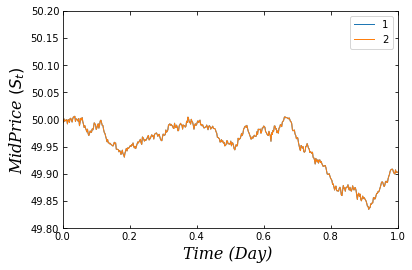

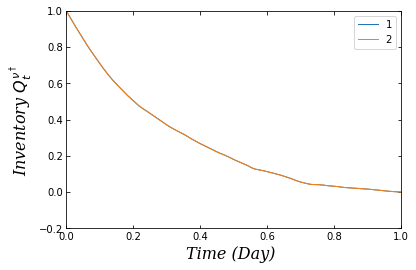

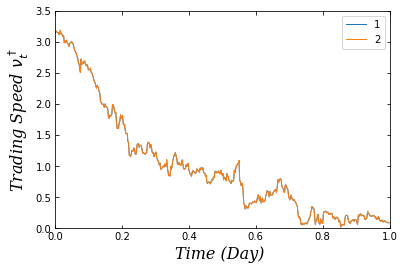

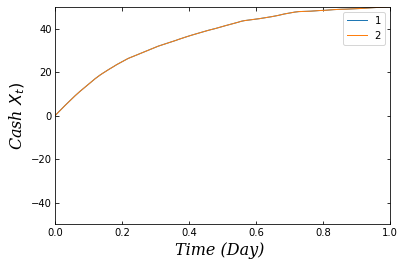

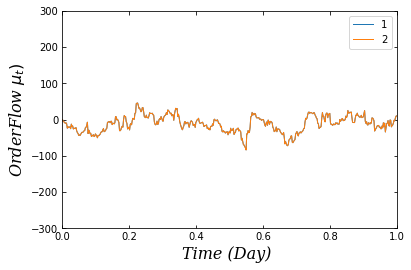

In [13]:
# Visualizing variables as time procresses 
idxfid = [0, 1]
OrderFlow_helpers.PlotPath(t, T, np.vstack([S_true, S_false]), idxfig, sigma, [initial_price - 2*sigma, initial_price + 2 * sigma], 'MidPrice ' + r'$(S_t)$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([Q_true, Q_false]), idxfig, sigma, [-2*sigma, initial_invt],'Inventory ' + r'$Q_t^{\nu^\dagger}$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([nu_true, nu_false]), idxfig, sigma, [0, 3.5], 'Trading Speed ' + r'$\nu_t^\dagger$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([X_true, X_false]), idxfig, sigma, [-50, 50], 'Cash ' + r'$X_t)$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([mu[0], mu[0]]), idxfig, sigma, [-300, 300], 'OrderFlow ' + r'$\mu_t)$')


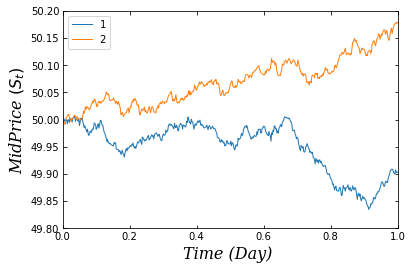

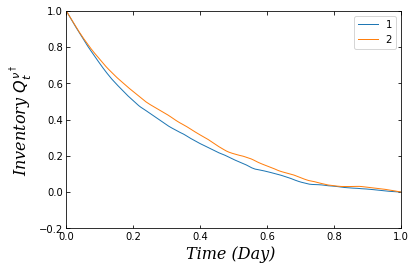

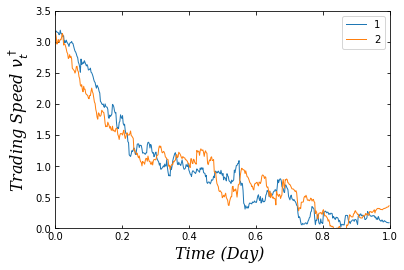

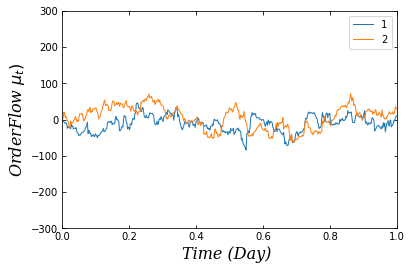

In [14]:
# Visualizing variables as time procresses 
OrderFlow_helpers.PlotPath(t, T, S, idxfig, sigma, [initial_price - 2*sigma, initial_price + 2 * sigma], 'MidPrice ' + r'$(S_t)$')
OrderFlow_helpers.PlotPath(t, T, Q, idxfig, sigma, [-2*sigma, initial_invt],'Inventory ' + r'$Q_t^{\nu^\dagger}$')
OrderFlow_helpers.PlotPath(t, T, nu, idxfig, sigma, [0, 3.5], 'Trading Speed ' + r'$\nu_t^\dagger$')
OrderFlow_helpers.PlotPath(t, T, mu, idxfig, sigma, [-300, 300], 'OrderFlow ' + r'$\mu_t)$')


In [15]:
import numpy as np

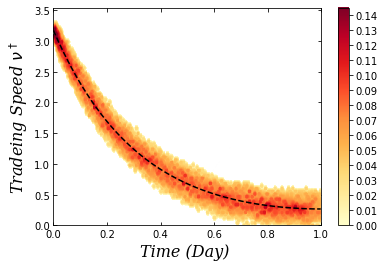

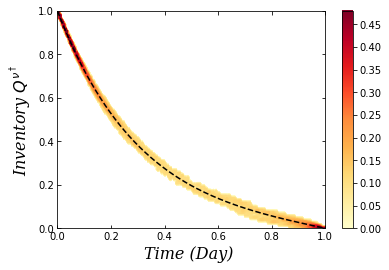

In [16]:
# Visualizing density plot of simulations
OrderFlow_helpers.PlotHeatMap(t, nu, nu_AC, 'Tradeing Speed ' + r'$\nu^\dagger$', n=40)
OrderFlow_helpers.PlotHeatMap(t, Q, Q_AC, 'Inventory ' + r'$Q^{\nu^\dagger}$', n=40, lower_threshold=0.05, upper_threshold=0.4)


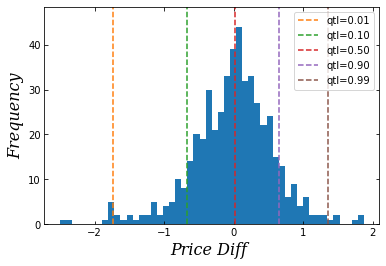

In [17]:
# Visualizing price difference between strategies 
fig_7 = plt.figure()
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
BasisPointSavings = ( X[:,-1]-X_AC[:, -1] ) / X_AC[:, -1] * 10**4

rets = plt.hist(BasisPointSavings, bins=50)

prob = [0.01, 0.1, 0.5, 0.9, 0.99]
q = np.quantile(BasisPointSavings, prob)
maxHeight = 1.1*np.max(rets[0])
for i in range(len(q)):
    plt.plot(q[i]*np.array([1,1]), np.array([0,maxHeight]), '--', label= prob[i])
plt.ylim((0,maxHeight))  
plt.ylabel('Frequency', fontdict=font)
plt.xlabel('Price Diff ', fontdict=font)
plt.legend(('qtl=0.01','qtl=0.10','qtl=0.50','qtl=0.90','qtl=0.99'))
plt.show()

# RL

In [18]:
def transform_state(state):
    return np.array([state[0][0], state[1][0], state[2][0], state[3][0]]).reshape(-1)

In [19]:
print('Final cash analytical solution:', X[:, -1])
print('Final cash RL:', env.simulator.X[:, -1])

Final cash analytical solution: [49.97158595 50.04005254 49.97412114 49.99135047 50.03930258 50.00541704
 50.04077356 50.01456738 50.020018   50.04682382 49.97430245 49.98168515
 49.91268668 49.95836382 50.03934272 50.06719621 49.97115796 49.9209508
 49.97862061 50.01568178 50.01579862 50.02014901 49.9990067  50.02011645
 50.06859317 50.03165113 49.95642056 49.97305101 50.01598077 50.0022198
 49.95363808 49.99771947 50.0364707  50.00833581 49.97704641 50.0173984
 49.96828163 49.98833248 49.96496585 49.98497307 49.9936988  50.02494281
 49.94223016 49.99740213 50.04018335 50.00983497 49.98527187 49.98248538
 49.97480475 49.99098455 50.0193262  50.0105919  49.99877984 50.06743293
 50.05208463 49.97024193 50.03508596 50.01790816 50.01039176 49.98912158
 49.97511402 50.03290761 49.95492955 49.99571158 49.98481877 49.92817889
 49.96669932 49.96755089 50.0038655  50.07547491 50.01153235 49.99388659
 50.00097037 50.04220426 50.003932   50.0219606  50.05390537 50.02492337
 49.98701428 50.063027

NameError: name 'env' is not defined

In [20]:
idxfig = [0, 1]

In [21]:
from SAC import Agent
import numpy as np
from collections import namedtuple, deque
import gym
from matplotlib import pyplot as plt
import pandas as pd
from DataHandler import DataHandler
from TradingEnv import TradingEnvironment
from TradingSimulatorBase import TradingSimulatorBase as TradingSimulatorBase
import torch
import numpy as np
seed = 1
n_episodes = 1
GAMMA = 0.99
TAU = 1e-2
HIDDEN_SIZE = 256
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64        # minibatch size
LR_ACTOR = 5e-4        # learning rate of the actor 
LR_CRITIC = 5e-4       # learning rate of the critic


Nsims = 1
Ndt = 500
dt = 1/Ndt
state_space_size = 1
continuous = False
min_action = 0
max_action = 1
dynamics_params = {
    'k': 0.001,
    'b': 0.0001,
    'lam': 1000,
    'kappa': 10,
    'kappa_false': 1,
    'eta_mean': 5,
    'phi': 0.1,
    'vol': 0.1,
    'alpha': 100
}
env_settings = {
    'Nsims': Nsims,
    'Ndt': Ndt,
    'state_space': gym.spaces.Box(0, 1, (state_space_size, )),
    'action_space': gym.spaces.Box(0, 1, (Nsims, )),
    'stochastic_reset': True,
    'misspecify': False,
    'dynamics_params': dynamics_params
}
simulator = TradingSimulatorBase#TradingSimulatorContinuous if continuous else TradingSimulatorDiscrete
env = TradingEnvironment(simulator, env_settings)
action_high = 1e-2
action_low = 1e-4
torch.manual_seed(seed)
np.random.seed(seed)
state_size = 4
action_size = 1
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed,hidden_size=HIDDEN_SIZE, action_prior="uniform") #"normal"

scores_deque = deque(maxlen=1000)
#average_100_scores = []

In [22]:
n_episodes = 3
for episode in range(n_episodes): 
    cur_state = env.reset()
    #env.simulator.mu = mu 
    #env.simulator.dW = dW 
    cur_state = transform_state(cur_state)
    avg_rewards = 0
    for i in range(Ndt):
      
        action = float(agent.act(cur_state))#, add_noise = True))
        action = np.clip(action*action_high, action_low, action_high) 
        new_state, reward, info, done = env.step(action*env.simulator.Q[:, env.simulator.step][0])
        new_state = transform_state(new_state)
        avg_rewards += reward[0]

        agent.step(cur_state, action, reward[0], new_state, done, i)
        cur_state = new_state
        if done == True:
            print('Episode', episode, '|| Avg reward:', avg_rewards/Ndt)
            break

Episode 0 || Avg reward: 0.045540382928033814
Episode 1 || Avg reward: 0.07349996573671724
Episode 2 || Avg reward: 0.08657790537319897


In [27]:
#  Simulating computed strategy
# Allocate space for the processes we simulate and store
Nsims = 1
mu = np.full([Nsims, Ndt+1], np.nan)  # Order Flow matrix

# Initializing variables for simulation base on computed strategy
X = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q = np.full([Nsims, Ndt+1], np.nan)  # Inventory matrix

S = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix

nu = np.full([Nsims, Ndt+1], np.nan)  # Rate of Trading matrix

# Initializing variables for simulation of Almgren-Chriss strategy
X_AC = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q_AC = np.full([Ndt+1], np.nan)  # Inventory matrix

S_AC = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix

nu_AC = np.full([Ndt+1], np.nan)  # Execution Price matrix
# Initial  conditions
Q[:, 0] = initial_invt
mu[:, 0] = 0
S[:, 0] = initial_price  
X[:, 0] = 0 

Q_AC[0] = initial_invt 
S_AC[:, 0] = initial_price
X_AC[:, 0] = 0
j = 0
rew = []
mu = env.simulator.mu
dW = env.simulator.dW
for i in range(Ndt):

    nu[:, i] = -1/k*chi[i]*Q[:, i] - 0.5 * b / k * ell[i] * mu[:, i]
    nu_AC[i] = -1/k*chi[i] * Q_AC[i]

    X[:, i + 1] = X[:, i] + (S[:, i] - k * nu[:, i]) * nu[:, i] * dt
    Q[:, i+1] = Q[:, i] - nu[:, i] * dt
    
    X_AC[:, i + 1] = X_AC[:, i] + (S_AC[:, i] - k * nu_AC[i]) * nu_AC[i] * dt
    Q_AC[i+1] = Q_AC[i] - nu_AC[i] * dt

    if Nsims > 1:
        S[:, i + 1] = S[:, i] + b * (mu[:, i] - nu[:, i]) * dt + (sigma * dW[:, i]).reshape(Nsims)
        S_AC[:, i + 1] = S_AC[:, i] + b * (mu[:, i] - nu_AC[i]) * dt + (sigma * dW[:, i]).reshape(Nsims)
    else:
        S[:, i + 1] = S[:, i] + b * (mu[:, i] - nu[:, i]) * dt + (sigma * dW[:, i])
        S_AC[:, i + 1] = S_AC[:, i] + b * (mu[:, i] - nu_AC[i]) * dt + (sigma * dW[:, i])


In [28]:
idxfig = [0, 1]

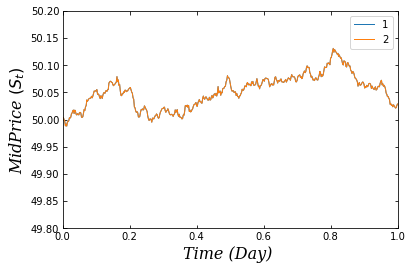

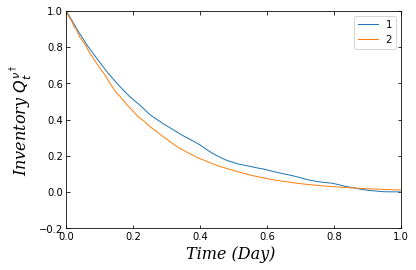

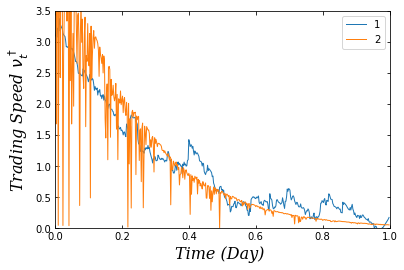

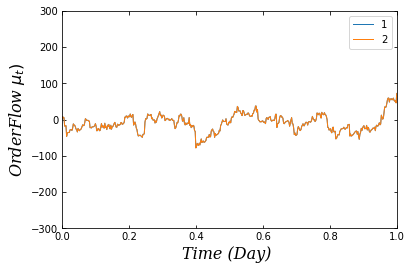

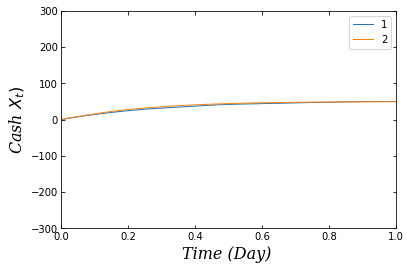

In [29]:
# Visualizing variables as time procresses 
OrderFlow_helpers.PlotPath(t, T, np.vstack([S, env.simulator.S]), idxfig, sigma, [initial_price - 2*sigma, initial_price + 2 * sigma], 'MidPrice ' + r'$(S_t)$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([Q, env.simulator.Q]), idxfig, sigma, [-2*sigma, initial_invt],'Inventory ' + r'$Q_t^{\nu^\dagger}$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([nu, env.simulator.actions]), idxfig, sigma, [0, 3.5], 'Trading Speed ' + r'$\nu_t^\dagger$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([mu, env.simulator.mu]), idxfig, sigma, [-300, 300], 'OrderFlow ' + r'$\mu_t)$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([X, env.simulator.X]), idxfig, sigma, [-300, 300], 'Cash ' + r'$X_t)$')


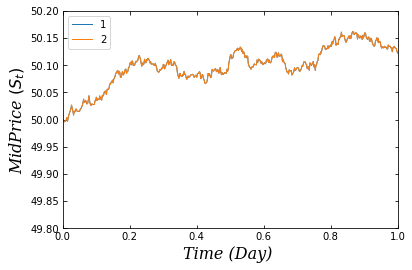

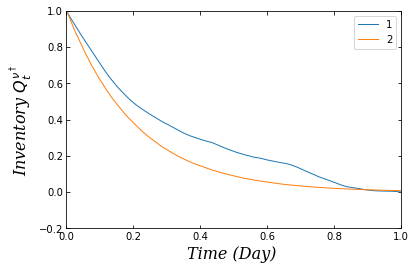

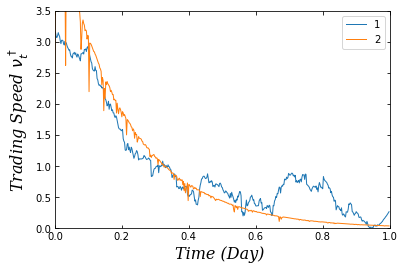

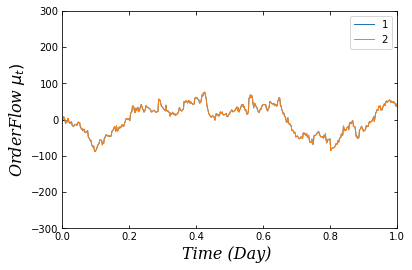

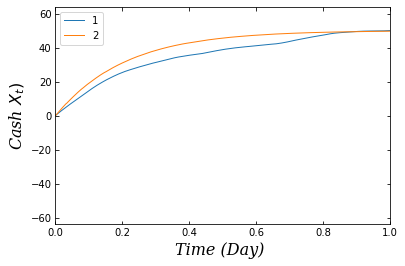

In [16]:
# Visualizing variables as time procresses 
OrderFlow_helpers.PlotPath(t, T, np.vstack([S, env.simulator.S]), idxfig, sigma, [initial_price - 2*sigma, initial_price + 2 * sigma], 'MidPrice ' + r'$(S_t)$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([Q, env.simulator.Q]), idxfig, sigma, [-2*sigma, initial_invt],'Inventory ' + r'$Q_t^{\nu^\dagger}$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([nu, env.simulator.actions]), idxfig, sigma, [0, 3.5], 'Trading Speed ' + r'$\nu_t^\dagger$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([mu, env.simulator.mu]), idxfig, sigma, [-300, 300], 'OrderFlow ' + r'$\mu_t)$')
OrderFlow_helpers.PlotPath(t, T, np.vstack([X, env.simulator.X]), idxfig, sigma, [-64, 64], 'Cash ' + r'$X_t)$')
